In [50]:
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import pylab as plt
from tqdm import tqdm

%matplotlib inline

In [11]:
IMG_PATH = './pic.jpg'

In [12]:
def load_image(path):
    return Image.open(path)

In [77]:
def init_hyperparams(im):
    W, H = im.size
    n, m = 16, 32
    S = 3
    L = H / n * W / m
    N = n * m * S
    alpha = np.array([0.001 for _ in range(L)])
    alpha_ = np.array([0.001 for _ in range(L)])
    return n, m, L, N, S, alpha, alpha_

n, m, L, N, S, alpha, alpha_ = init_hyperparams(load_image(IMG_PATH))
print init_hyperparams(load_image(IMG_PATH))

(16, 32, 128, 1536, 3, array([ 0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,

In [20]:
def transform_pixel(P):
    C_MAX = 255.0
    P = np.array(P)
    return (2.0 * P / C_MAX) - 1.0

def transform_area(im, lu_corner, rb_corner):
    X0, Y0 = lu_corner
    X1, Y1 = rb_corner
    
    def transform(x, y):
        return transform_pixel(im.getpixel((x, y)))
    
    q = []
    for x in range(X0, X1 + 1):
        for y in range(Y0, Y1 + 1):
            q.append(transform(x, y))
    return np.array(q).flatten()

def transform_image(im, n, m):
    
    def transform(i, j):
        lu = (i, j)
        rb = (i + n - 1, j + m - 1)
        return transform_area(im, lu, rb)
    
    transformed = []
    for i in range(0, im.height, n):
        for j in range(0, im.width, m):
            transformed.append(transform(i, j))
    
    return np.array(transformed)

In [88]:
def init():
    im = load_image(IMG_PATH)
    n, m, L, N, S, alpha, alpha_ = init_hyperparams(im)
    
    p = 100
#     W1 = np.ones((N, p))
    W1 = np.random.rand(N, p)
    W2 = W1.T
    X = transform_image(im, n, m)
    
    return im, X, W1, W2, alpha, alpha_

In [89]:
def get_Z(N, L, p):
    return ((N + L) * p + 2.0) / (N * L)

print get_Z(N, L, 100)

0.846364339193


In [86]:
def run(EPS, STEPS):
    im, X, W, W_, alpha, alpha_ = init()
    
    def pass_through(X, W, W_):
        Y = X.dot(W)
        X_ = Y.dot(W_)
        delta_X = X_ - X
        return X_, Y, delta_X
        
    def adjust_w1(alpha, W, X, delta_X, W_):
        return W - (alpha * X.T).dot(delta_X).dot(W_.T)
    
    def adjust_w2(alpha_, W_, Y, delta_X):
        return W_ - (alpha_ * Y.T).dot(delta_X)
    
    def adjust_alpha(alpha, X):
        return 1.0 / (X * X).sum(axis=1)
    
    def normalize(W):g
        return W / abs(W.max())
    
    def error(delta_X):
        return np.linalg.norm(delta_X)
    
    current_error = 1e15
    step = 0
    min_error_found = current_error
    steps = []
    errors = []
    with tqdm(total=STEPS) as pbar:
        while current_error > EPS and step < STEPS:
            step += 1
            X_, Y, delta_X = pass_through(X, W, W_)
            W = normalize(adjust_w1(alpha, W, X, delta_X, W_))
            W_ = normalize(adjust_w2(alpha_, W_, Y, delta_X))
            alpha_ = adjust_alpha(alpha_, Y)
#             alpha = alpha + adjust_alpha(alpha, X)
            current_error = error(delta_X)
            steps.append(step)
            errors.append(current_error)
            pbar.update(1)
        
    return np.array(steps), np.array(errors), W, W_, X_

In [79]:
def viz(name, steps, errors):
    plt.figure(figsize=(16, 7))
    plt.plot(steps, np.log(errors))
    plt.title(name)
    plt.xlabel('Step')
    plt.ylabel('log(Error)')
    plt.show()

100%|██████████| 10000/10000 [03:46<00:00, 44.22it/s]


Min error 593.359717133


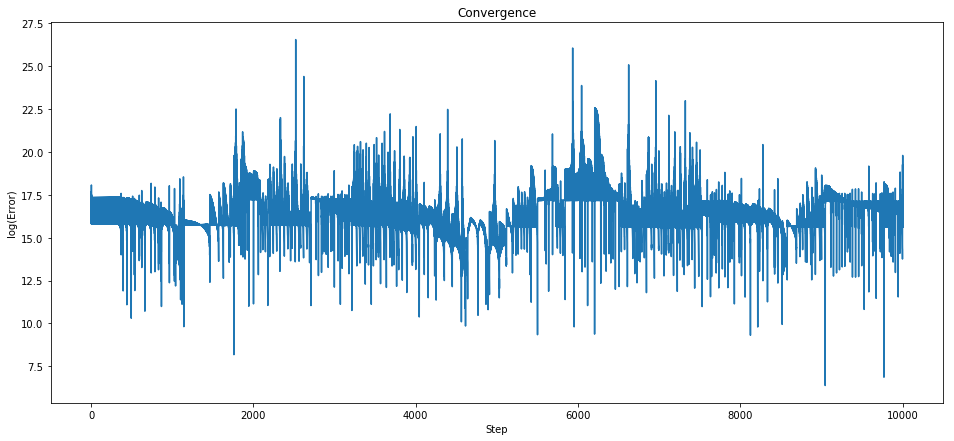

In [55]:
steps, errors, W, W_, X_ = run(2.0, 10000)
print 'Min error', errors.min()
viz('Convergence (111)', steps, errors)

100%|██████████| 10000/10000 [03:49<00:00, 43.54it/s]


Min error 514.456658758


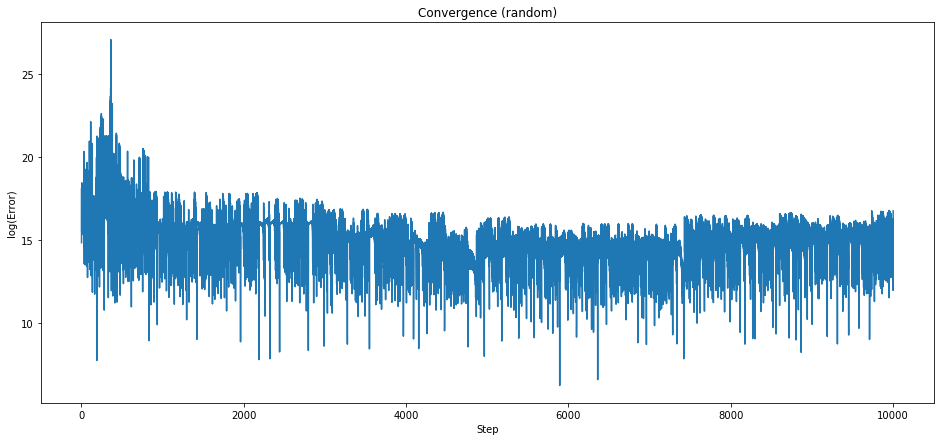

In [62]:
steps, errors, W, W_, X_ = run(2.0, 10000)
print 'Min error', errors.min()
viz('Convergence (random)', steps, errors)

100%|██████████| 1000/1000 [02:10<00:00,  7.97it/s]


Min error 56238881.8183


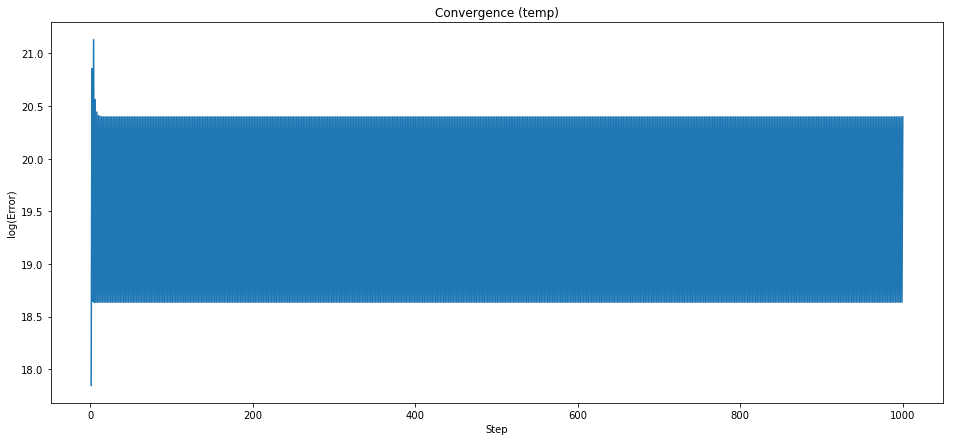

In [84]:
steps, errors, W, W_, X_ = run(2.0, 1000)
print 'Min error', errors.min()
viz('Convergence (temp)', steps, errors)

In [64]:
a = np.random.rand(5, 3)
print a
b = np.random.rand(3, 5)
print (a*b.T).shape
print a / a.max()
print a.sum(axis=1)
print a*a
print (a*a).sum(axis=1)

[[ 0.9861451   0.86247126  0.686754  ]
 [ 0.77848064  0.42179486  0.07038811]
 [ 0.18460489  0.88925236  0.58831157]
 [ 0.80853901  0.34725245  0.4876276 ]
 [ 0.32230457  0.20626908  0.22068651]]
(5, 3)
[[ 1.          0.8745886   0.69640259]
 [ 0.78941795  0.42772089  0.07137703]
 [ 0.1871985   0.90174597  0.59657709]
 [ 0.81989862  0.35213119  0.49447855]
 [ 0.32683281  0.20916707  0.22378706]]
[ 2.53537036  1.27066361  1.66216882  1.64341905  0.74926017]
[[ 0.97248215  0.74385667  0.47163106]
 [ 0.60603211  0.1779109   0.00495449]
 [ 0.03407896  0.79076977  0.34611051]
 [ 0.65373533  0.12058426  0.23778068]
 [ 0.10388024  0.04254693  0.04870254]]
[ 2.18796988  0.7888975   1.17095924  1.01210026  0.19512971]
